<a href="https://colab.research.google.com/github/finesketch/deep_learning/blob/main/4.%20Sequences%2C%20Time%20Series%20and%20Prediction/Course4_Part3_Lesson2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [4]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)

np.random.seed()

In [6]:
train_set = windowed_dataset(x_train, window_size, batch_size=120, shuffle_buffer=shuffle_buffer_size)

In [7]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

In [8]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

In [9]:
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

In [10]:
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])

In [11]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
9/9 [==============================] - 0s 28ms/step - loss: 195.5540 - mae: 196.0540
Epoch 2/100
9/9 [==============================] - 0s 25ms/step - loss: 194.6122 - mae: 195.1122
Epoch 3/100
9/9 [==============================] - 0s 24ms/step - loss: 193.1169 - mae: 193.6169
Epoch 4/100
9/9 [==============================] - 0s 25ms/step - loss: 191.2587 - mae: 191.7587
Epoch 5/100
9/9 [==============================] - 0s 27ms/step - loss: 189.0870 - mae: 189.5870
Epoch 6/100
9/9 [==============================] - 0s 24ms/step - loss: 186.5977 - mae: 187.0977
Epoch 7/100
9/9 [==============================] - 0s 25ms/step - loss: 183.7452 - mae: 184.2452
Epoch 8/100
9/9 [==============================] - 0s 25ms/step - loss: 180.4800 - mae: 180.9800
Epoch 9/100
9/9 [==============================] - 0s 24ms/step - loss: 176.7385 - mae: 177.2385
Epoch 10/100
9/9 [==============================] - 0s 25ms/step - loss: 172.4277 - mae: 172.9277
Epoch 11/100
9/9 [===========

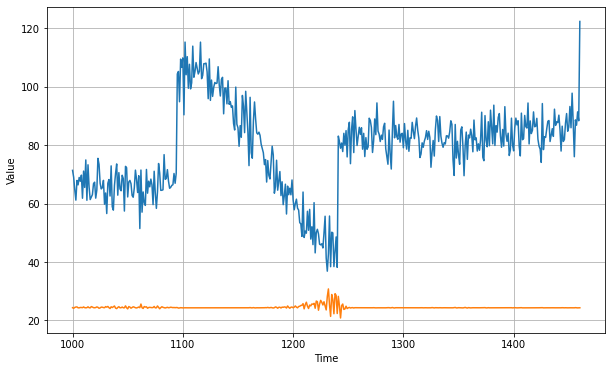

In [12]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:,0,0]

plt.figure(figsize=(10,6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

53.96266

(1e-08, 0.0001, 0.0, 30.0)

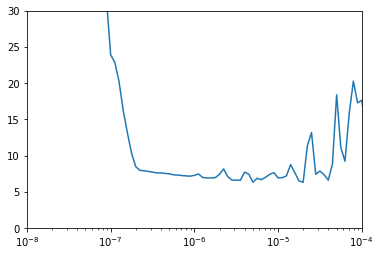

In [15]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

In [16]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)

np.random.seed(51)

In [17]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer=shuffle_buffer_size)

In [18]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

In [19]:
optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)

In [20]:
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])

In [21]:
history = model.fit(dataset, epochs=400)

Epoch 1/400
31/31 [==============================] - 1s 26ms/step - loss: 30.4413 - mae: 30.9358
Epoch 2/400
31/31 [==============================] - 1s 27ms/step - loss: 24.6163 - mae: 25.1124
Epoch 3/400
31/31 [==============================] - 1s 27ms/step - loss: 13.5835 - mae: 14.0787
Epoch 4/400
31/31 [==============================] - 1s 28ms/step - loss: 13.4384 - mae: 13.9317
Epoch 5/400
31/31 [==============================] - 1s 26ms/step - loss: 12.0105 - mae: 12.5008
Epoch 6/400
31/31 [==============================] - 1s 26ms/step - loss: 11.7650 - mae: 12.2574
Epoch 7/400
31/31 [==============================] - 1s 26ms/step - loss: 14.4562 - mae: 14.9502
Epoch 8/400
31/31 [==============================] - 1s 26ms/step - loss: 8.8445 - mae: 9.3340
Epoch 9/400
31/31 [==============================] - 1s 26ms/step - loss: 15.9052 - mae: 16.3981
Epoch 10/400
31/31 [==============================] - 1s 27ms/step - loss: 14.3506 - mae: 14.8425
Epoch 11/400
31/31 [===========

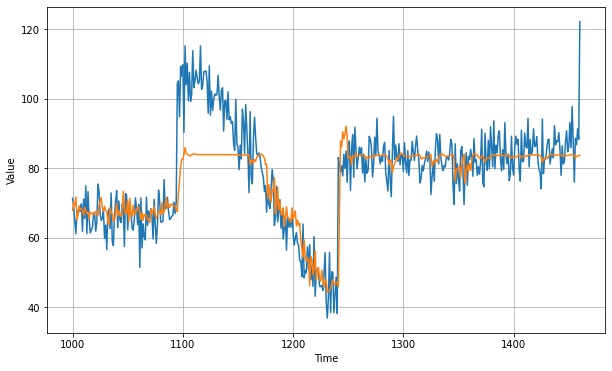

In [22]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:,0,0]

plt.figure(figsize=(10,6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [23]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.31893

<Figure size 432x288 with 0 Axes>

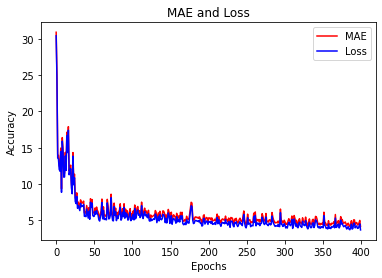

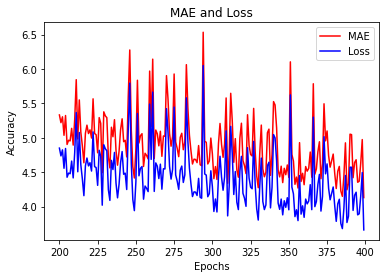

<Figure size 432x288 with 0 Axes>

In [24]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['MAE', "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['MAE', 'Loss'])

plt.figure()

In [26]:
i = 0
for x, y in dataset:
  i += 1
  print('x = ', x.numpy())
  print('y = ', y.numpy())
  print('x (expend_dims) = ', tf.expand_dims(x, axis=-1))
  if i == 1:
    break


x =  [[33.46019   52.195435  52.991413  36.417343  45.094387  44.97436
  39.817963  42.99061   41.351192  55.690018  51.631855  53.336246
  50.61204   41.383835  44.43211   49.527397  40.9959    50.697735
  45.95752   45.31164  ]
 [38.251995  32.812275  20.062172  25.247257  34.012722  24.14989
  29.917734  31.582527  23.085745  27.434132  11.5371    22.63349
  26.50489   21.541426  35.955315  20.655773  25.61978   28.487524
  35.054302  20.683037 ]
 [22.74508   11.99279   15.311469  29.109999  29.892042  19.817163
  23.34403   21.420355  34.665504  24.280306  17.458702  12.741154
   8.912089  17.392189  12.028938   8.140686  11.465986   8.743816
  22.045954  17.48329  ]
 [32.268925  29.094048  24.697277  29.591013  25.8548    34.145004
  28.563086  25.200027  27.749893  31.45096   26.59733   25.334665
  30.694183  30.730724  27.001482  27.211473  30.757544  22.38766
  22.621704  26.097902 ]
 [30.41058   30.84493   25.66792   30.18544   30.446434  25.366972
  38.226013  31.225473  22.8